# Predicting bike sharing data

This neural network project predicts bike-sharing rides, applicable for bike sharing companies like CycleHop. This could be used to get the right number of bicycles to maximise the revenue in accordance with the law of supply and demand. The historical data available in Bike-Sharing-Dataset folder is used as the training data set. The data comes from the [UCI Machine Learning Database](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). The project was submitted as a part of Udacity Deep Learning course.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

Pandas library is used to load the data in a tabular manner.

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Understanding the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. 

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, there is also information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. 

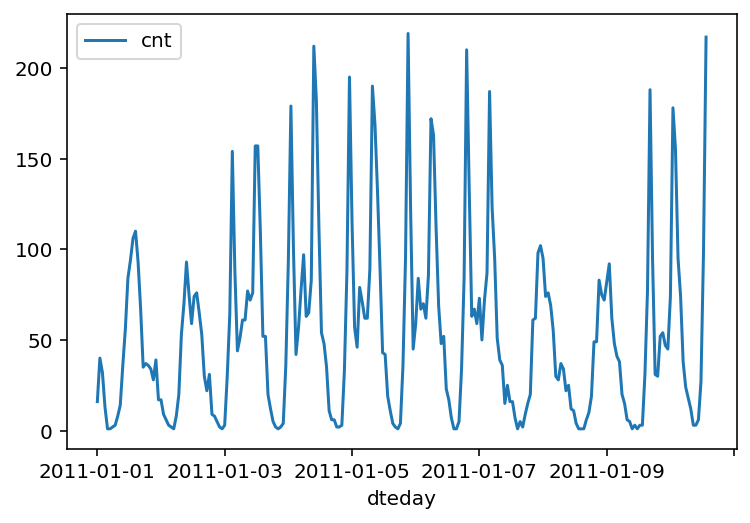

In [3]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables

There are some categorical variables like season, weather, month. To include these in the model, binary dummy variables are made.

In [4]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training network easier, each of the continuous variables is standardised. Hence, the variables have zero mean and a standard deviation of 1. The scaling factors are saved to be used in the network for predictions.

In [5]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

The data for the last approximately 21 days is used as a test set after training the network. This set is used to compare the predictions with the actual number of riders.

In [6]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

The data is split into two sets, one for training and one for validating as the network is being trained. 

In [7]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Build the network

The neural network is constructed for a regression problem type by implementing forward pass and backpropagation. Sigmoid function is used as an activation function.

In [8]:
import numpy as np


class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### Set activation functions ####
        self.activation_function = lambda x : 1 / (1 + np.exp(-x)) 
        self.activation_function_derivative = lambda x : self.activation_function(x)*(1-self.activation_function(x))
        
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            # Implement the forward pass function
            final_outputs, final_inputs, hidden_outputs, hidden_inputs = self.forward_pass_train(X)  
            # Implement the backproagation function 
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, final_inputs, hidden_outputs, hidden_inputs, X, y, 
                                                                        delta_weights_i_h, delta_weights_h_o)
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)


    def forward_pass_train(self, X):
        ''' Implement forward pass here 
         
            Arguments
            ---------
            X: features batch

        '''
        ### Forward pass ###
        # Hidden layer
        hidden_inputs = np.dot(X,self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

        # Output layer 
        final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs
        
        return final_outputs, final_inputs, hidden_outputs, hidden_inputs

    def backpropagation(self, final_outputs, final_inputs, hidden_outputs, hidden_inputs, X, y, 
                        delta_weights_i_h, delta_weights_h_o):
        ''' Implement backpropagation
         
            Arguments
            ---------
            final_outputs: output from forward pass
            y: target (i.e. label) batch
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers

        '''
        ### Backward pass ###

        # Output error
        error = (y-final_outputs) # Output layer error is the difference between desired target and actual output.
        
        #Output error term
        output_error_term = error
        
        # Hidden layer's contribution to the error
        hidden_error = output_error_term.dot(self.weights_hidden_to_output.T)
        
        # Error term for hidden layer
        hidden_error_term = hidden_error * self.activation_function_derivative(hidden_inputs)
              
        # Weight step (input to hidden)
        delta_weights_h_o += (output_error_term * hidden_outputs[None,:]).T
        
        # Weight step (hidden to output)
        delta_weights_i_h += hidden_error_term[:,None].dot(X[None,:]).T
        
        return delta_weights_i_h, delta_weights_h_o

    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        ''' Update weights on gradient descent step
         
            Arguments
            ---------
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records

        '''
        # update hidden-to-output and input-to-hidden weights with gradient descent step
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records 
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records 

    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Forward pass ####
        # Hidden layer 
        hidden_inputs = np.dot(features,self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # Output layer
        final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        return final_outputs

In [9]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

The hyperparameters for the network are set below. The strategy here is to find hyperparameters such that the error on the training set is low, but the data does not overfit. Stochastic Gradient Descent is used to train the network. For each training pass, only a random sample of the data is taken instead of using the whole data set. 

In [10]:
#########################################################
# Set hyperparameters 
##########################################################
iterations = 2000
learning_rate = 1
hidden_nodes = 10
output_nodes = 1

In [11]:
import sys

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.loc[batch].values, train_targets.loc[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.078 ... Validation loss: 0.166

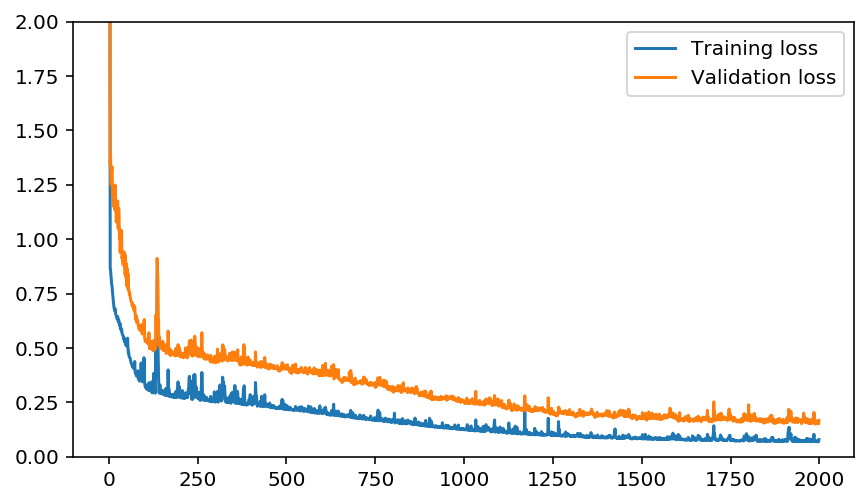

In [12]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
ax.set_ylim((0, 2))
_ = plt.ylim()

## Check out predictions

Here the test data is viewed against the model predictions.

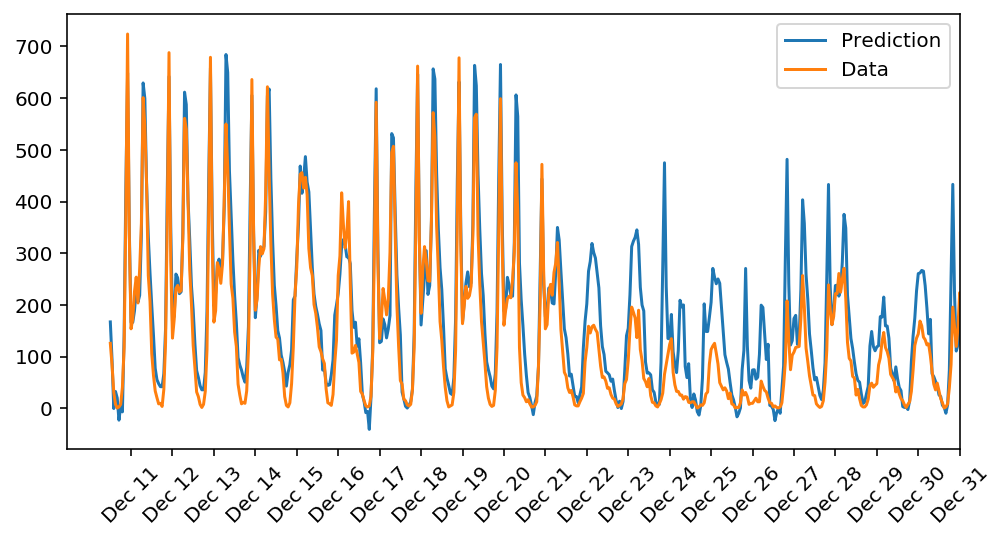

In [13]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

#dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## Results analysis

The model predicts the number of riders relatively well. The peaks that occur during the day are not perfectly captured, although increasing the number of iterations improved the response. It can be seen from the graph above that the model overestimates the number of riders after 21st of December. This is because the train data did not include the Christmas time when people use the bikes much less frequently.